# Gradient Descent and Backpropagation
### Understanding the math behind gradient descent and how to implement backprogagation in python
--------------------
**Author: Jay Mody**

**Required Knowledge:**
- Basic Python Skills
- Numpy
- Calculus (derivatives, gradients, chain rule)
- Linear Algebra (matrices, matrix multiplication)

## MNIST DATA

In [10]:
# #### Imports ####
# import sys
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from matplotlib.colors import ListedColormap
# from sklearn.datasets import make_blobs

# # #### Data Parameters ####
# n_features = 784  # n_input_nodes
# n_classes = 10 # n_output_nodes

# colors_list = ['red', 'cyan', 'magenta', 'green', 'black', 'blue']
# colors = ListedColormap(colors_list)

# ##  Loading Data  ##
# mnist = tf.keras.datasets.mnist
# (x_train, y_train_raw), (x_test, y_test_raw) = mnist.load_data()

# # Flattening for mlp
# x_train = x_train.reshape(x_train.shape[0], 784)
# x_test = x_test.reshape(x_test.shape[0], 784)

# print(x_train.shape) #--> (60000, 28, 28)
# print(y_train_raw.shape) #--> (60000,)
# print(x_test.shape) #--> (10000, 28, 28)
# print(y_test_raw.shape) #--> (10000,)

# ##  Normalizing Data  ##
# normal_val = 255

# x_train = np.divide(x_train, normal_val)
# x_test = np.divide(x_test, normal_val)

# ##  Splitting Data into Validation and Train Sets  ##
# percent_train = 0.80

# train_samples = int(percent_train * len(x_train))
# val_x = x_train[train_samples:]
# x_train = x_train[:train_samples]

# target_samples = int(percent_train * len(y_train_raw))
# val_y = y_train_raw[target_samples:]
# y_train_raw = y_train_raw[:target_samples]

# ## One Hot Encoding Y_train for training ##
# y_train = np.zeros((y_train_raw.shape[0], n_classes))
# y_train[np.arange(y_train_raw.size), y_train_raw] = 1

# ## One Hot Encoding Y_test for testing ##
# y_test = np.zeros((y_test_raw.shape[0], n_classes))
# y_test[np.arange(y_test_raw.size), y_test_raw] = 1

## Data

In [11]:
#### Imports ####
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_blobs


#### Data Parameters ####
n_features = 2  # n_input_nodes
n_classes = 3 # n_output_nodes

n_training_samples = 300 
n_testing_samples = 200

cluster_std = 0.5
center_box = (-2, 2)

colors_list = ['red', 'cyan', 'magenta', 'green', 'black', 'blue']
colors = ListedColormap(colors_list)

seed = 45



#### Training Data ####
x_train, y_train_raw = make_blobs(n_samples = n_training_samples, 
                                  n_features = n_features,
                                  centers = n_classes,
                                  center_box = center_box,
                                  cluster_std =  cluster_std, 
                                  random_state = seed)

# One-hot encodes the y values (categorically encoding the data)
y_train = np.zeros((y_train_raw.shape[0], n_classes))
y_train[np.arange(y_train_raw.size), y_train_raw] = 1



#### Testing Data ####
x_test, y_test_raw = make_blobs(n_samples = n_testing_samples + n_training_samples, 
                            n_features = n_features,
                            centers = n_classes,
                            center_box = center_box,
                            cluster_std =  cluster_std, 
                            random_state = seed)
x_test = x_test[-n_testing_samples:]
y_test_raw = y_test_raw[-n_testing_samples:]

# One-hot encodes the y values (categorically encoding the data)
y_test = np.zeros((y_test_raw.shape[0], n_classes))
y_test[np.arange(y_test_raw.size), y_test_raw] = 1

### Datasets

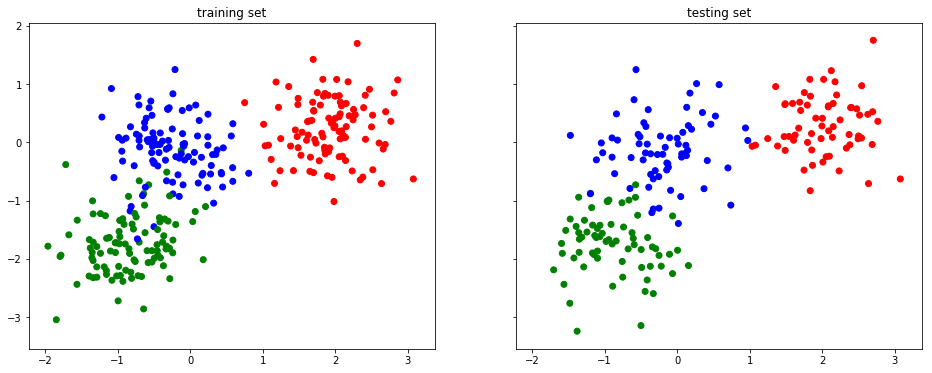

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, sharex = True, figsize=(16, 6))

_ = ax1.scatter(x_train[:, 0], x_train[:, 1], c = y_train_raw, cmap = colors)
_ = ax1.set_title('training set')

_ = ax2.scatter(x_test[:, 0], x_test[:, 1], c = y_test_raw, cmap = colors)
_ = ax2.set_title('testing set')

## Neural Network

In [13]:
#### Neural Network Class ####
class NeuralNetwork:
    ##### Constructor ####
    def __init__(self, n_input_nodes, hidden_nodes, n_output_nodes, lr):
        ## Network ##
        self.n_input_nodes = n_input_nodes
        self.n_output_nodes = n_output_nodes
        
        self.nodes = hidden_nodes
        self.nodes.insert(0, n_input_nodes)
        self.nodes.append(n_output_nodes)
        
        ## Weights and Biases##
        self.weights = []
        self.biases = []
        for i in range(1, len(self.nodes)):
            self.weights.append(np.random.uniform(-1.0, 1.0, (self.nodes[i-1], self.nodes[i])))
            self.biases.append(np.random.uniform(-1.0, 1.0, (1, self.nodes[i])))
        
        ## Learning Rate ##
        self.lr = lr
        
        ## Activation Functions ##
        # Linear Activation
        self.linear = lambda x: x
        self.d_linear = lambda x: np.ones(x.shape)
        
        # Relu Activation
        def relu(x):
            x[x<0] = 0
            return x
        def d_relu(out):
            out: x[x>0] = 1
            return out
        self.relu = relu
        self.d_relu = d_relu
            
        # Sigmoid Activation
        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.d_sigmoid = lambda out: out * (1 - out)  # assumes out is tanh(x)
        
        # Hyperbolic Tangent Activation
        self.tanh = lambda x: np.tanh(x)
        self.d_tanh = lambda out: 1 - out**2 # assumes out is tanh(x)
        
    def getWeights(self):
        return self.weights.copy()
    def getBiases(self):
        return self.biases.copy()
    
    def setWeights(self, weights):
        self.weights = weights.copy()
    def setBiases(self, biases):
        self.biases = biases.copy()
    
    #### Feed Forward ####
    def feed_forward(self, X):
        outputs = []
        
        logits = np.dot(X, self.weights[0]) + self.biases[0]
        
        for i in range(1, len(self.nodes) - 1):
            out = self.relu(logits)
            outputs.append(out)
            logits = np.dot(out, self.weights[i]) + self.biases[i]
        
        out = self.sigmoid(logits)
        outputs.append(out)
        
        return outputs
    
    #### Backpropagation ####
    def backpropagation(self, X, y, outputs):
        weights_gradients = []
        biases_gradients = []
        
        d1 = y - outputs[-1]
        d2 = self.d_sigmoid(outputs[-1])
        error = d1 * d2
        
        grad = outputs[-2].T * error 
        weights_gradients.append(grad)
        biases_gradients.append(error)
        
        for i in range(len(outputs) - 2, 1, -1):
            d = self.d_relu(outputs[i])
            error = np.dot(error, self.weights[i+1].T) * d
            
            grad = outputs[i-1].T * error 
            weights_gradients.append(grad)
            biases_gradients.append(error)
        
        return weights_gradients, biases_gradients
    
    #### Training ####
    def train(self, features, targets):
        # Batch Size for weight update step
        batch_size = features.shape[0]
        
        # Delta Weights Variables
        delta_weights = [np.zeros(weight.shape) for weight in self.weights]
        delta_biases = [np.zeros(bias.shape) for bias in self.biases]
        
        # For every data point, forward pass, backpropogation, store weights change
        for X, y in zip(features, targets):
            # Forward pass
            X = X.reshape(1, X.shape[0])
            outputs = self.feed_forward(X)
            
            # Back propogation
            weights_gradients, biases_gradients = self.backpropagation(X, y, outputs)
            
            for i in range(len(weights_gradients)):
                delta_weights[-(i+1)] += weights_gradients[i]
                delta_biases[-(i+1)] += biases_gradients[i]
        
        for i in range(len(delta_weights)):
            self.weights[i] += (self.lr * delta_weights[i]) / batch_size
            self.biases[i] += (self.lr * delta_biases[i]) / batch_size

    #### Testing Methods ####
    def predict(self, X):
        # Gives prediction
        return self.feed_forward(X)[-1]
    
    def test(self, features, targets):
        predictions = self.predict(features)

        n_correct = 0
        for i in range(len(predictions)):
            prediction = np.argmax(predictions[i])
            correct = np.argmax(targets[i])

            if prediction == correct:
                n_correct += 1

        return n_correct / len(targets)

### Helper Methods

In [14]:
def MSE(y, y_hat):
    return np.mean((y-y_hat)**2)

def generate_area_map(features, points_per_int = 10, alpha = 0.2):
    ###  Area Map Set  ###
    xstart = int((features[:, 0].min() - 1) * points_per_int) # min start point of the x data
    xrang = int((features[:, 0].max() + 1) * points_per_int - xstart) # range of the data on x

    ystart = int((features[:, 1].min()  - 1) * points_per_int) # min start poing of the y data
    yrang = int((features[:, 1].max() + 1) * points_per_int - ystart) # range of teh data on y

    # Creates an array with all the coordinates of area map set
    area_map_set = np.array([[x + xstart, y + ystart] for x in range(xrang) for y in range(yrang)])
    area_map_set = area_map_set / points_per_int
    
    return area_map_set

def area_map_plot(network, area_map_set, features, targets, path = '', alpha = 0.1):
    # gets the prediction the model made for the area map set
    pred = network.predict(area_map_set)
    pred = [pred[i,:].argmax() for i in range(int(pred.shape[0]))]

    # draws the current area map and the test set overtop it, saves the scatter
    plt.scatter(features[:, 0], features[:, 1], c = targets, cmap =colors)
    plt.scatter(area_map_set[:, 0], area_map_set[:, 1], c = pred, alpha = alpha, cmap = colors)
    
    if path == '':
        plt.show()
    else:
        plt.savefig(path)
        plt.close()

## Network and Parameters

In [15]:
#### Network Parameters ####
n_input_nodes = n_features
n_output_nodes = n_classes

n_hidden_nodes = [64, 32]

n_epochs = 4000
lr = 0.01
batch_size = 64

#### Neural Network ####
network = NeuralNetwork(n_input_nodes, n_hidden_nodes, n_output_nodes, lr)

### Control Test

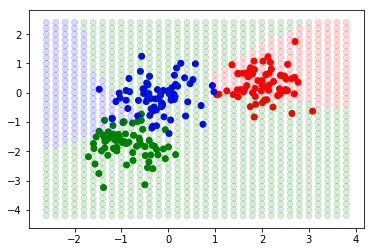

Accuracy on Train Set: 0.5566666666666666
Accuracy on Test Set: 0.575


In [16]:
area_map_set = generate_area_map(x_test, points_per_int = 5)
area_map_plot(network, area_map_set, x_test, y_test_raw, alpha = 0.15)
    
print("Accuracy on Train Set:", network.test(x_train, y_train))
print("Accuracy on Test Set:", network.test(x_test, y_test))

## Train

In [17]:
#### Train ####
losses = {'train':[], 'validation':[]}
accuracy = {'train':[], 'validation':[]}

for epoch in range(n_epochs):
    batch_indices = np.random.choice(list(range(x_train.shape[0])), size = batch_size)
    features = np.array([x_train[i] for i in batch_indices])
    targets = np.array([y_train[i] for i in batch_indices])
    
    network.train(features, targets)
    
    # Printing out the training progress
    train_loss = MSE(network.predict(x_train).T, y_train_raw)
    val_loss = MSE(network.predict(x_test).T, y_test_raw)
    train_acc = network.test(x_train, y_train)
    val_acc = network.test(x_train, y_train)
    sys.stdout.write("\rProgress: {:2.1f}%".format(100 * epoch/float(n_epochs)) \
                     + " ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5] \
                     + " ... Training Acc: " + str(train_acc)[:5] \
                     + " ... Validation Acc: " + str(val_acc)[:5])
    sys.stdout.flush()

    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)
    accuracy['train'].append(train_acc)
    accuracy['validation'].append(val_acc)

Progress: 100.0% ... Training loss: 1.282 ... Validation loss: 1.307 ... Training Acc: 0.956 ... Validation Acc: 0.956

### Loss Graph

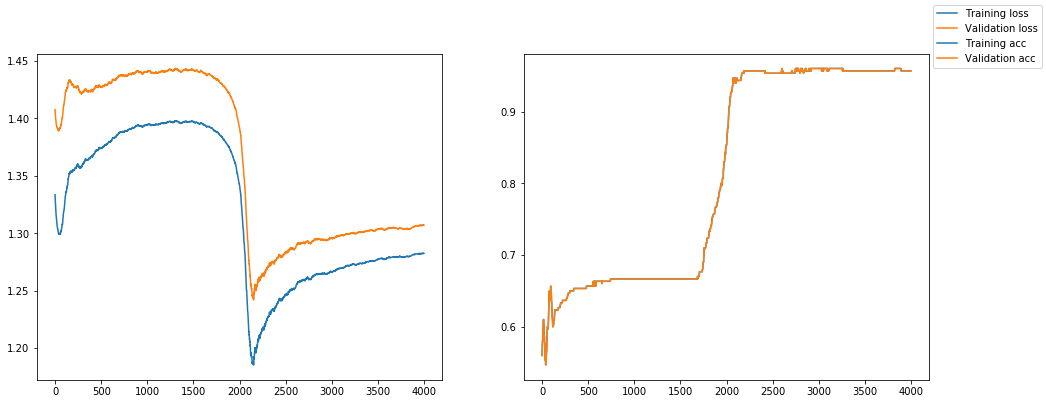

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = False, sharex = False, figsize=(16, 6))

_ = ax1.plot(losses['train'], label='Training loss')
_ = ax1.plot(losses['validation'], label='Validation loss')

_ = ax2.plot(accuracy['train'], label='Training acc')
_ = ax2.plot(accuracy['validation'], label='Validation acc')

_ = fig.legend()

## Testing

In [19]:
print("Accuracy on Train Set:", network.test(x_train, y_train))
print("Accuracy on Test Set:", network.test(x_test, y_test))

Accuracy on Train Set: 0.9566666666666667
Accuracy on Test Set: 0.96


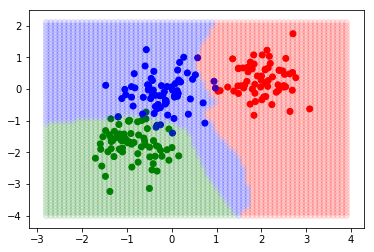

In [20]:
area_map_set = generate_area_map(features)
area_map_plot(network, area_map_set, x_test, y_test_raw)

In [ ]:
#### END OF NOTEBOOK ####